### <b>APLICACION DE LA ARQUITECTURA VGG A LA SOLUCION DE UN PROBLEMA DE CLASIFICACION MULTICLASE<br>
DATASET Intel Image Classification</b>
<br>
<br>
<hr>
Freddy Alvarado Bazán
<br>
Junio 2021 - Lima Perú
Ultima actualización: 20/06/2021 06:00 PM
<hr>

**INSTALACION DE LIBRERIAS**

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 102kB 5.7MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=0925477bbccd56da78c45d9b5b6bae4f636d78f02905e8d29321a703a2e49845
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


**REFRENCIANDO LIBRERIAS**

**Generales**

In [ ]:
# No mostrar Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from PIL import Image

In [ ]:
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1gSEZeMSh28UNSDZFcdZMM1bnAlkctArS')

     |████████████████████████████████| 71kB 4.6MB/s 


**De uso común**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import kerastuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

**Cargando DataSet desde kaggle.com**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"freddyalvarado","key":"0fc94294f92b2c9e6cc3dc67d935f5fe"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 332M/346M [00:03<00:00, 126MB/s]
100% 346M/346M [00:03<00:00, 111MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('/content/intel-image-classification.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

##Directorios de trabajo

In [ ]:
train_dir  = ('/tmp/seg_train/seg_train')
validation_dir = ('/tmp/seg_test/seg_test')
preds_dir = ('/tmp/seg_pred/seg_pred')

In [ ]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['/tmp/seg_train/seg_train', '/tmp/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output


In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  4%|▍         | 95/2404 [00:00<00:02, 947.15it/s]

Loading /tmp/seg_train/seg_train


 31%|███▏      | 173/553 [00:00<00:00, 1726.41it/s]

Loading /tmp/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 1591.46it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
train_images.shape

(14034, 150, 150, 3)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Número de ejemplos de entrenamiento: {}".format(n_train))
print ("Número de ejemplos de prueba: {}".format(n_test))
print ("Tamaño de cada imagen: {}".format(IMAGE_SIZE))

Número de ejemplos de entrenamiento: 14034
Número de ejemplos de prueba: 3000
Tamaño de cada imagen: (150, 150)


In [ ]:
def mDevCategoria(cols):
  Etiqueta = cols[0]
  PClass = cols[1]

  if pd.isnull(PClass):
 
    if (Etiqueta==0):
        return 'mountain'

    if (Etiqueta==1):
        return 'street'

    if (Etiqueta==2):
      return 'glacier'

    if (Etiqueta==3):
      return 'buildings'

    if (Etiqueta==4):
        return 'sea'

    if (Etiqueta==5):
        return 'forest'


In [ ]:
df = pd.DataFrame({'Etiqueta_train':train_labels })
df['Categoria'] = None

In [ ]:
df['Categoria'] = df[['Etiqueta_train','Categoria']].apply(mDevCategoria,axis=1)
df

,Etiqueta_train,Categoria
0,0,mountain
1,3,buildings
2,1,street
3,1,street
4,3,buildings
...,...,...
14029,5,forest
14030,4,sea
14031,3,buildings
14032,0,mountain


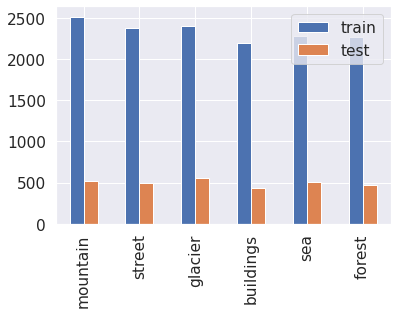

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

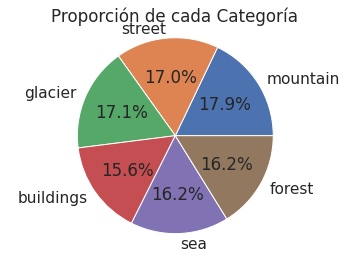

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporción de cada Categoría')
plt.show()

In [ ]:
#Escalamiento
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
# Muestra imagen aleaotria
def display_random_image(class_names, images, labels):   
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

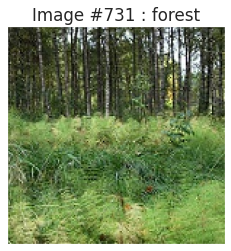

In [ ]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):   
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

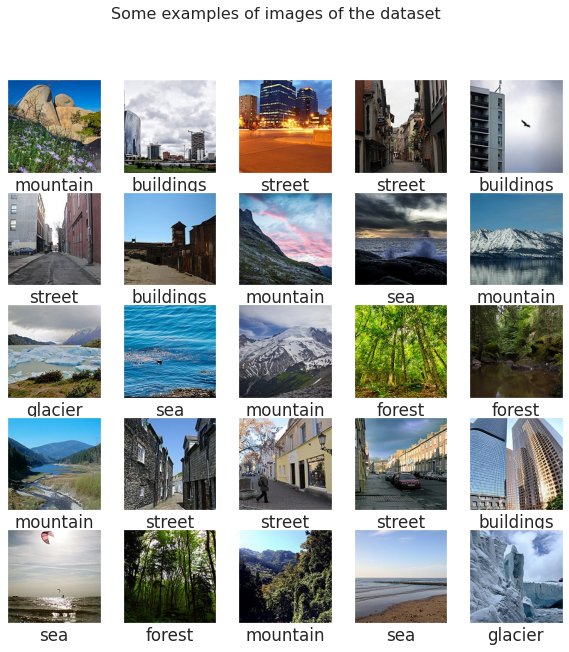

In [ ]:
display_examples(class_names, train_images, train_labels)

## **MODELAMIENTO Y OPTIMIZACION**

##**CNN - Modelo Básico**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 19s 44ms/step - loss: 1.3816 - accuracy: 0.5209 - val_loss: 0.9236 - val_accuracy: 0.6655
Epoch 2/20
88/88 [==============================] - 3s 37ms/step - loss: 0.7999 - accuracy: 0.7033 - val_loss: 0.7671 - val_accuracy: 0.7228
Epoch 3/20
88/88 [==============================] - 3s 37ms/step - loss: 0.6605 - accuracy: 0.7593 - val_loss: 0.7090 - val_accuracy: 0.7335
Epoch 4/20
88/88 [==============================] - 3s 37ms/step - loss: 0.5076 - accuracy: 0.8203 - val_loss: 0.6254 - val_accuracy: 0.7766
Epoch 5/20
88/88 [==============================] - 3s 37ms/step - loss: 0.3872 - accuracy: 0.8663 - val_loss: 0.6808 - val_accuracy: 0.7684
Epoch 6/20
88/88 [==============================] - 3s 37ms/step - loss: 0.2769 - accuracy: 0.9115 - val_loss: 0.7454 - val_accuracy: 0.7684
Epoch 7/20
88/88 [==============================] - 3s 37ms/step - loss: 0.2075 - accuracy: 0.9343 - val_loss: 0.7547 - val_accuracy: 0.7709
Epoch 8/20
8

In [ ]:
df2 = pd.DataFrame(history.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,1.381557,0.520887,0.923624,0.665479
1,0.799943,0.703305,0.767081,0.722836
2,0.660475,0.759330,0.708975,0.733523
3,0.507636,0.820255,0.625391,0.776630
4,0.387169,0.866304,0.680815,0.768436
5,0.276932,0.911463,0.745424,0.768436
6,0.207527,0.934266,0.754688,0.770930
7,0.132939,0.961878,0.743366,0.781617
8,0.084164,0.978623,0.862704,0.784111
9,0.067210,0.982809,1.026563,0.752048


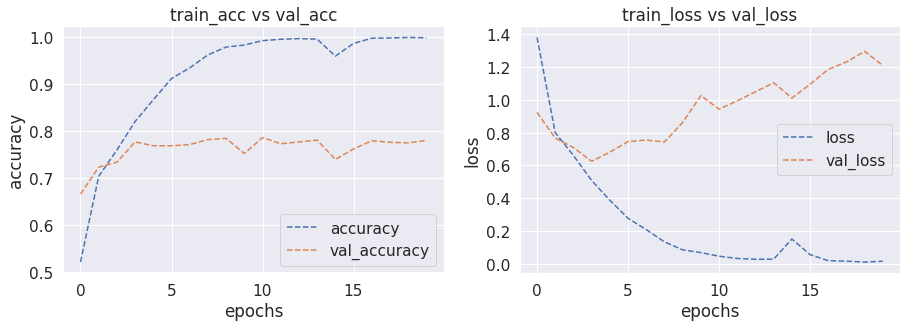

In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], '--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'--', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 6ms/step - loss: 1.2475 - accuracy: 0.7693


In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability


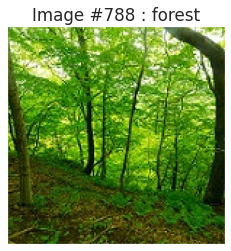

In [ ]:
# Validando la predicción con las imágenes de prueba
# en algunos casos no coincide
display_random_image(class_names, test_images, pred_labels)

**Error de Análisis**

In [ ]:
# Función que muestra 25 imágenes al azar y muestra su etiqueta predicha
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

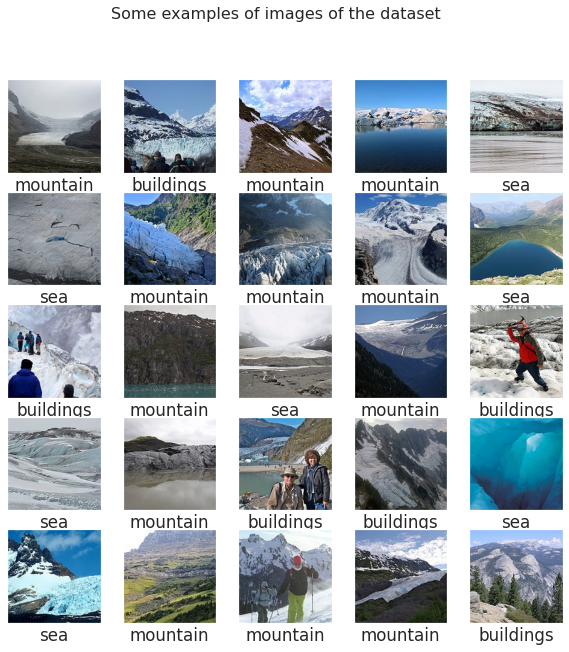

In [ ]:
# Notar que existe error en algunas preedicciones
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

**Matriz de Confusión**

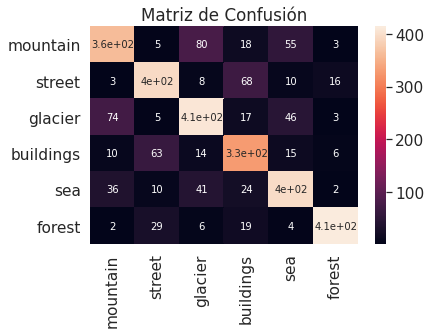

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Matriz de Confusión')
plt.show()

**RESULTADOS OBTENIDOS**
<br>Modelo: **CNN Básico**
<br>
Accuracy: **0.7693**
<br>
loss: **1.2475**
<br>
tiempo promedio por paso: **6 ms/step**

##**Extracción de características con VGG ImageNet**

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Predicciones usando VGG ImageNet
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z
print('Cantidad de características: {}'.format(numFeatures))

Cantidad de características: 8192


**PCA**

In [ ]:
from sklearn import decomposition
pca = decomposition.PCA(n_components = 2)
X = train_features.reshape((n_train, x*y*z))
pca.fit(X)
C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

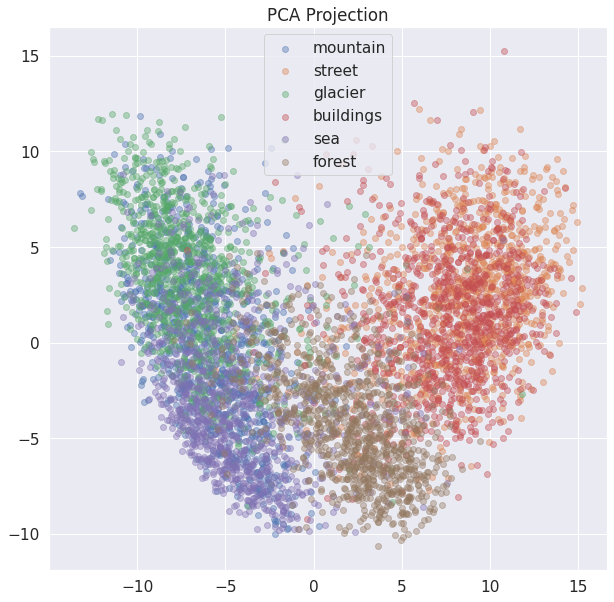

In [ ]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

**COMENTARIOS**
<br>
El gráfico de los componentes principales (PCA) muestra clusters débilmente definidos para algunas categorías. La categoría forest se muestra ligeramente mas diferenciada que el resto de categorías lo que indica que el modelo de clasificación es suceptible de mejora. 

**Modelo: VGG**

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])
model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=500, validation_split = 0.2)

Epoch 1/500
88/88 [==============================] - 1s 6ms/step - loss: 0.5367 - accuracy: 0.8064 - val_loss: 0.3929 - val_accuracy: 0.8568
Epoch 2/500
88/88 [==============================] - 0s 4ms/step - loss: 0.3050 - accuracy: 0.8901 - val_loss: 0.3306 - val_accuracy: 0.8835
Epoch 3/500
88/88 [==============================] - 0s 4ms/step - loss: 0.2436 - accuracy: 0.9123 - val_loss: 0.3216 - val_accuracy: 0.8860
Epoch 4/500
88/88 [==============================] - 0s 4ms/step - loss: 0.2088 - accuracy: 0.9287 - val_loss: 0.3501 - val_accuracy: 0.8782
Epoch 5/500
88/88 [==============================] - 0s 4ms/step - loss: 0.1772 - accuracy: 0.9401 - val_loss: 0.3715 - val_accuracy: 0.8636
Epoch 6/500
88/88 [==============================] - 0s 4ms/step - loss: 0.1555 - accuracy: 0.9483 - val_loss: 0.3342 - val_accuracy: 0.8828
Epoch 7/500
88/88 [==============================] - 0s 4ms/step - loss: 0.1290 - accuracy: 0.9580 - val_loss: 0.3611 - val_accuracy: 0.8721
Epoch 8/500
8

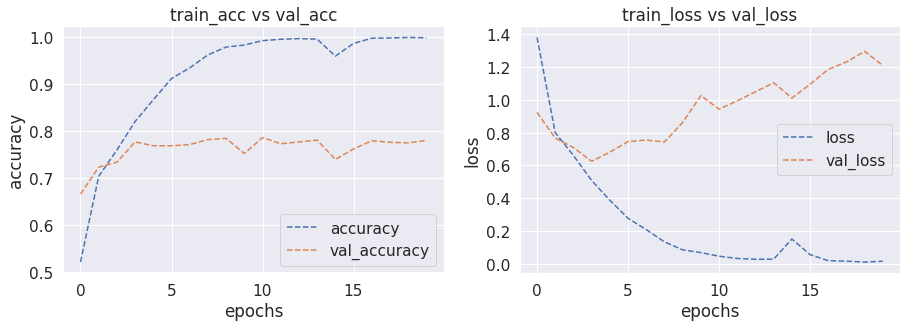

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 1.2629 - accuracy: 0.8640


**Conclusiones - Modelo VGG**
El modelo de CNN básico obtiene un valor de Accuracy de 0.7693 el cual es susceptible de mejora.

**RESULTADOS OBTENIDOS**
<br>Modelo: **VGG**
<br>
Accuracy: **0.8640**
<br>
loss: **1.2629**
<br>
tiempo promedio por paso: **2 ms/step**

##**Ensemble Neural Networks**

In [ ]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

Definimos redes neuronales n_estimators.

Cada red neuronal se entrenará en subconjuntos aleatorios del conjunto de datos de entrenamiento. Cada subconjunto contiene muestras de max_samples.

In [ ]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [ ]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 5ms/step - loss: 0.5156 - accuracy: 0.8101 - val_loss: 0.3505 - val_accuracy: 0.8887
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 0.2460 - accuracy: 0.9157 - val_loss: 0.2902 - val_accuracy: 0.9029
Epoch 3/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1793 - accuracy: 0.9414 - val_loss: 0.2670 - val_accuracy: 0.9190
Epoch 4/10
79/79 [==============================] - 0s 4ms/step - loss: 0.1387 - accuracy: 0.9558 - val_loss: 0.2295 - val_accuracy: 0.9297
Epoch 5/10
79/79 [==============================] - 0s 4ms/step - loss: 0.0947 - accuracy: 0.9734 - val_loss: 0.2402 - val_accuracy: 0.9297
Epoch 6/10
79/79 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9732 - val_loss: 0.2308 - val_accuracy: 0.9288
Epoch 7/10
79/79 [==============================] - 0s 4ms/step - loss: 0.0617 - accuracy: 0.9840 - val_loss: 0.2197 - val_accuracy: 0.9412
Epoch 8/10
79/79 [==

In [ ]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8903333333333333


**RESULTADOS OBTENIDOS**
<br>Modelo\Técnica: **Ensemble Neural Netoworks**
<br>
Accuracy: **0.8903**
<br>
loss: **1.2203**
<br>
tiempo promedio por paso: **4 ms/step**

**Fine Tuning VGG ImageNet**

In [ ]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=500, validation_split = 0.2)

Epoch 1/500
88/88 [==============================] - 13s 54ms/step - loss: 1.4402 - accuracy: 0.5306 - val_loss: 0.4204 - val_accuracy: 0.8486
Epoch 2/500
88/88 [==============================] - 4s 42ms/step - loss: 0.3768 - accuracy: 0.8648 - val_loss: 0.3305 - val_accuracy: 0.8938
Epoch 3/500
88/88 [==============================] - 4s 42ms/step - loss: 0.2792 - accuracy: 0.9010 - val_loss: 0.3174 - val_accuracy: 0.8938
Epoch 4/500
88/88 [==============================] - 4s 42ms/step - loss: 0.2334 - accuracy: 0.9158 - val_loss: 0.3306 - val_accuracy: 0.8949
Epoch 5/500
88/88 [==============================] - 4s 42ms/step - loss: 0.1879 - accuracy: 0.9317 - val_loss: 0.3143 - val_accuracy: 0.8956
Epoch 6/500
88/88 [==============================] - 4s 42ms/step - loss: 0.1667 - accuracy: 0.9425 - val_loss: 0.3498 - val_accuracy: 0.8864
Epoch 7/500
88/88 [==============================] - 4s 42ms/step - loss: 0.1309 - accuracy: 0.9491 - val_loss: 0.3341 - val_accuracy: 0.9120
Epoch

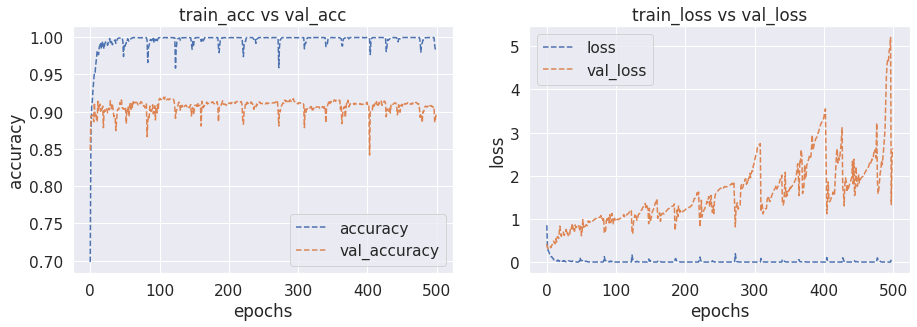

In [ ]:
plot_accuracy_loss(history)

In [ ]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8936666666666667


**RESULTADOS OBTENIDOS**
<br>Modelo\Técnica: **Fine Tuning VGG**
<br>
Accuracy: **0.8936**
<br>
loss: **1.2103**
<br>
tiempo promedio por paso: **4 ms/step**

# **CONCLUSIONES**

Se observa que se logra una mejora en el modelo de clasificación luego de aplicar la arquitectura de red neuronal del tipo VGG asi como técnicas de afinamiento, pasando de un valor de accuracy de **0.7693** hasta **0.8936** tal como se puede apreciar en la Tabla 1.

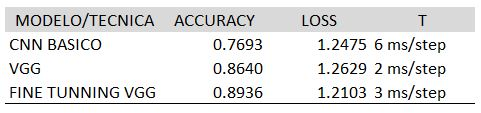
<br>
Tabla1: Resumen

El análisis gráfico de la mejora de la exactitud o accuracy, de igual manera se puede evidenciar en los siguientes gráficos.

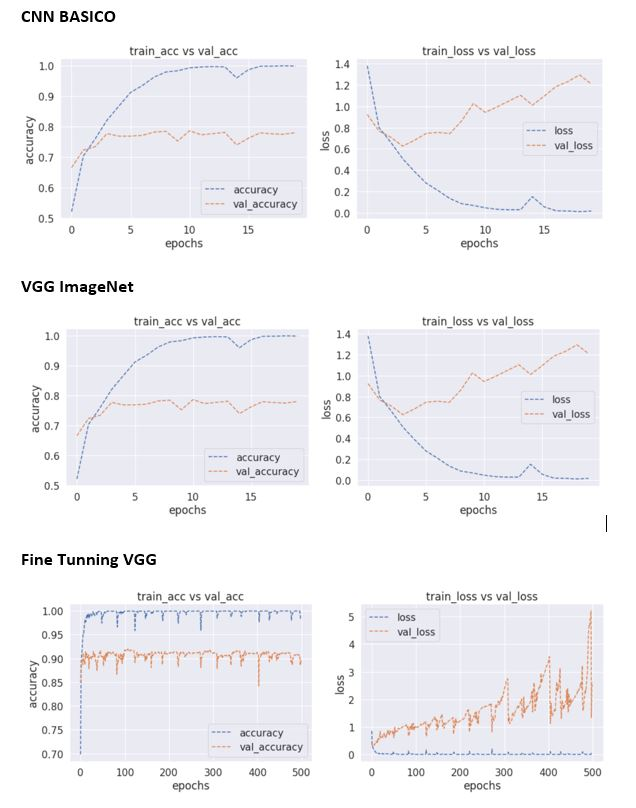

# RECOMENDACION
El resultado obtenido es susceptible de mejora, se recomienda probar otros modelos de Redes Neuronales Convolucionales como: MobileNet, ResNet, SqueezeNet entre otras.